In [6]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\ank10ki\Dropbox\phd\Image analysis\ColonyImages`


In order to speed up computation, the creation and analysis of the colonies is multithreaded. To further enhance performance, execute this notebook with a Julia kernel that utilizes more threads, ideally matching the number of threads your CPU supports. Learn how to set up a Julia kernel with more threads [here](https://discourse.julialang.org/t/enable-multiple-cores-for-jupyter-lab/18658/5).

In [7]:
Threads.nthreads()

8

In [8]:
using Revise, CairoMakie
using ColonyImages
using DataFrames, CSV, FileIO, Dates, Serialization
import ColorSchemes as co 

In [9]:
df = DataFrame(data_set =String[], colony = String[], time = Int[], 
    metric_OG =Vector{Vector{Int64}}(undef,0), metric_cov = Vector{Vector{Int64}}(undef,0),
    pair_OG =Vector{Vector{Int64}}(undef,0),pair_cov =Vector{Vector{Int64}}(undef,0),
    OG_size = Int[], border_points =Vector{Vector{CartesianIndex{2}}}(undef,0), Parameters = Vector{parameters}(undef,0) )

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size,border_points,Parameters
,String,String,Int64,Array…,Array…,Array…,Array…,Int64,Array…,paramete…


In [10]:
para = parameters(
        im_size = [800,800],
        time_points = [0:4.0:52...],
        colony_nr = 8, 
        number_finger = 15,
        spawn_rate = 0.1,
        dir_match_rate_C = 0.9993,
        dir_match_rate_B = 0.9993,
        growth_rate = [0.02971700864000873,0.0,.0,.0])

simulations = ["Random", "Finger_weak", "Finger_strong"]


Points= lattice_points(Int(maximum(para.im_size)÷2));

## Create empty datastructure for colony images

In [11]:
vec_of_sims = initialize_colonies(para, simulations)

3-element Vector{Vector{BitArray{3}}}:
 [[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; … ;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; … ;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; … ;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0;;; 0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0

In [17]:
growth_colonies!(vec_of_sims, para, Points)

### Plot first colony test wise to see if everything worked as intended

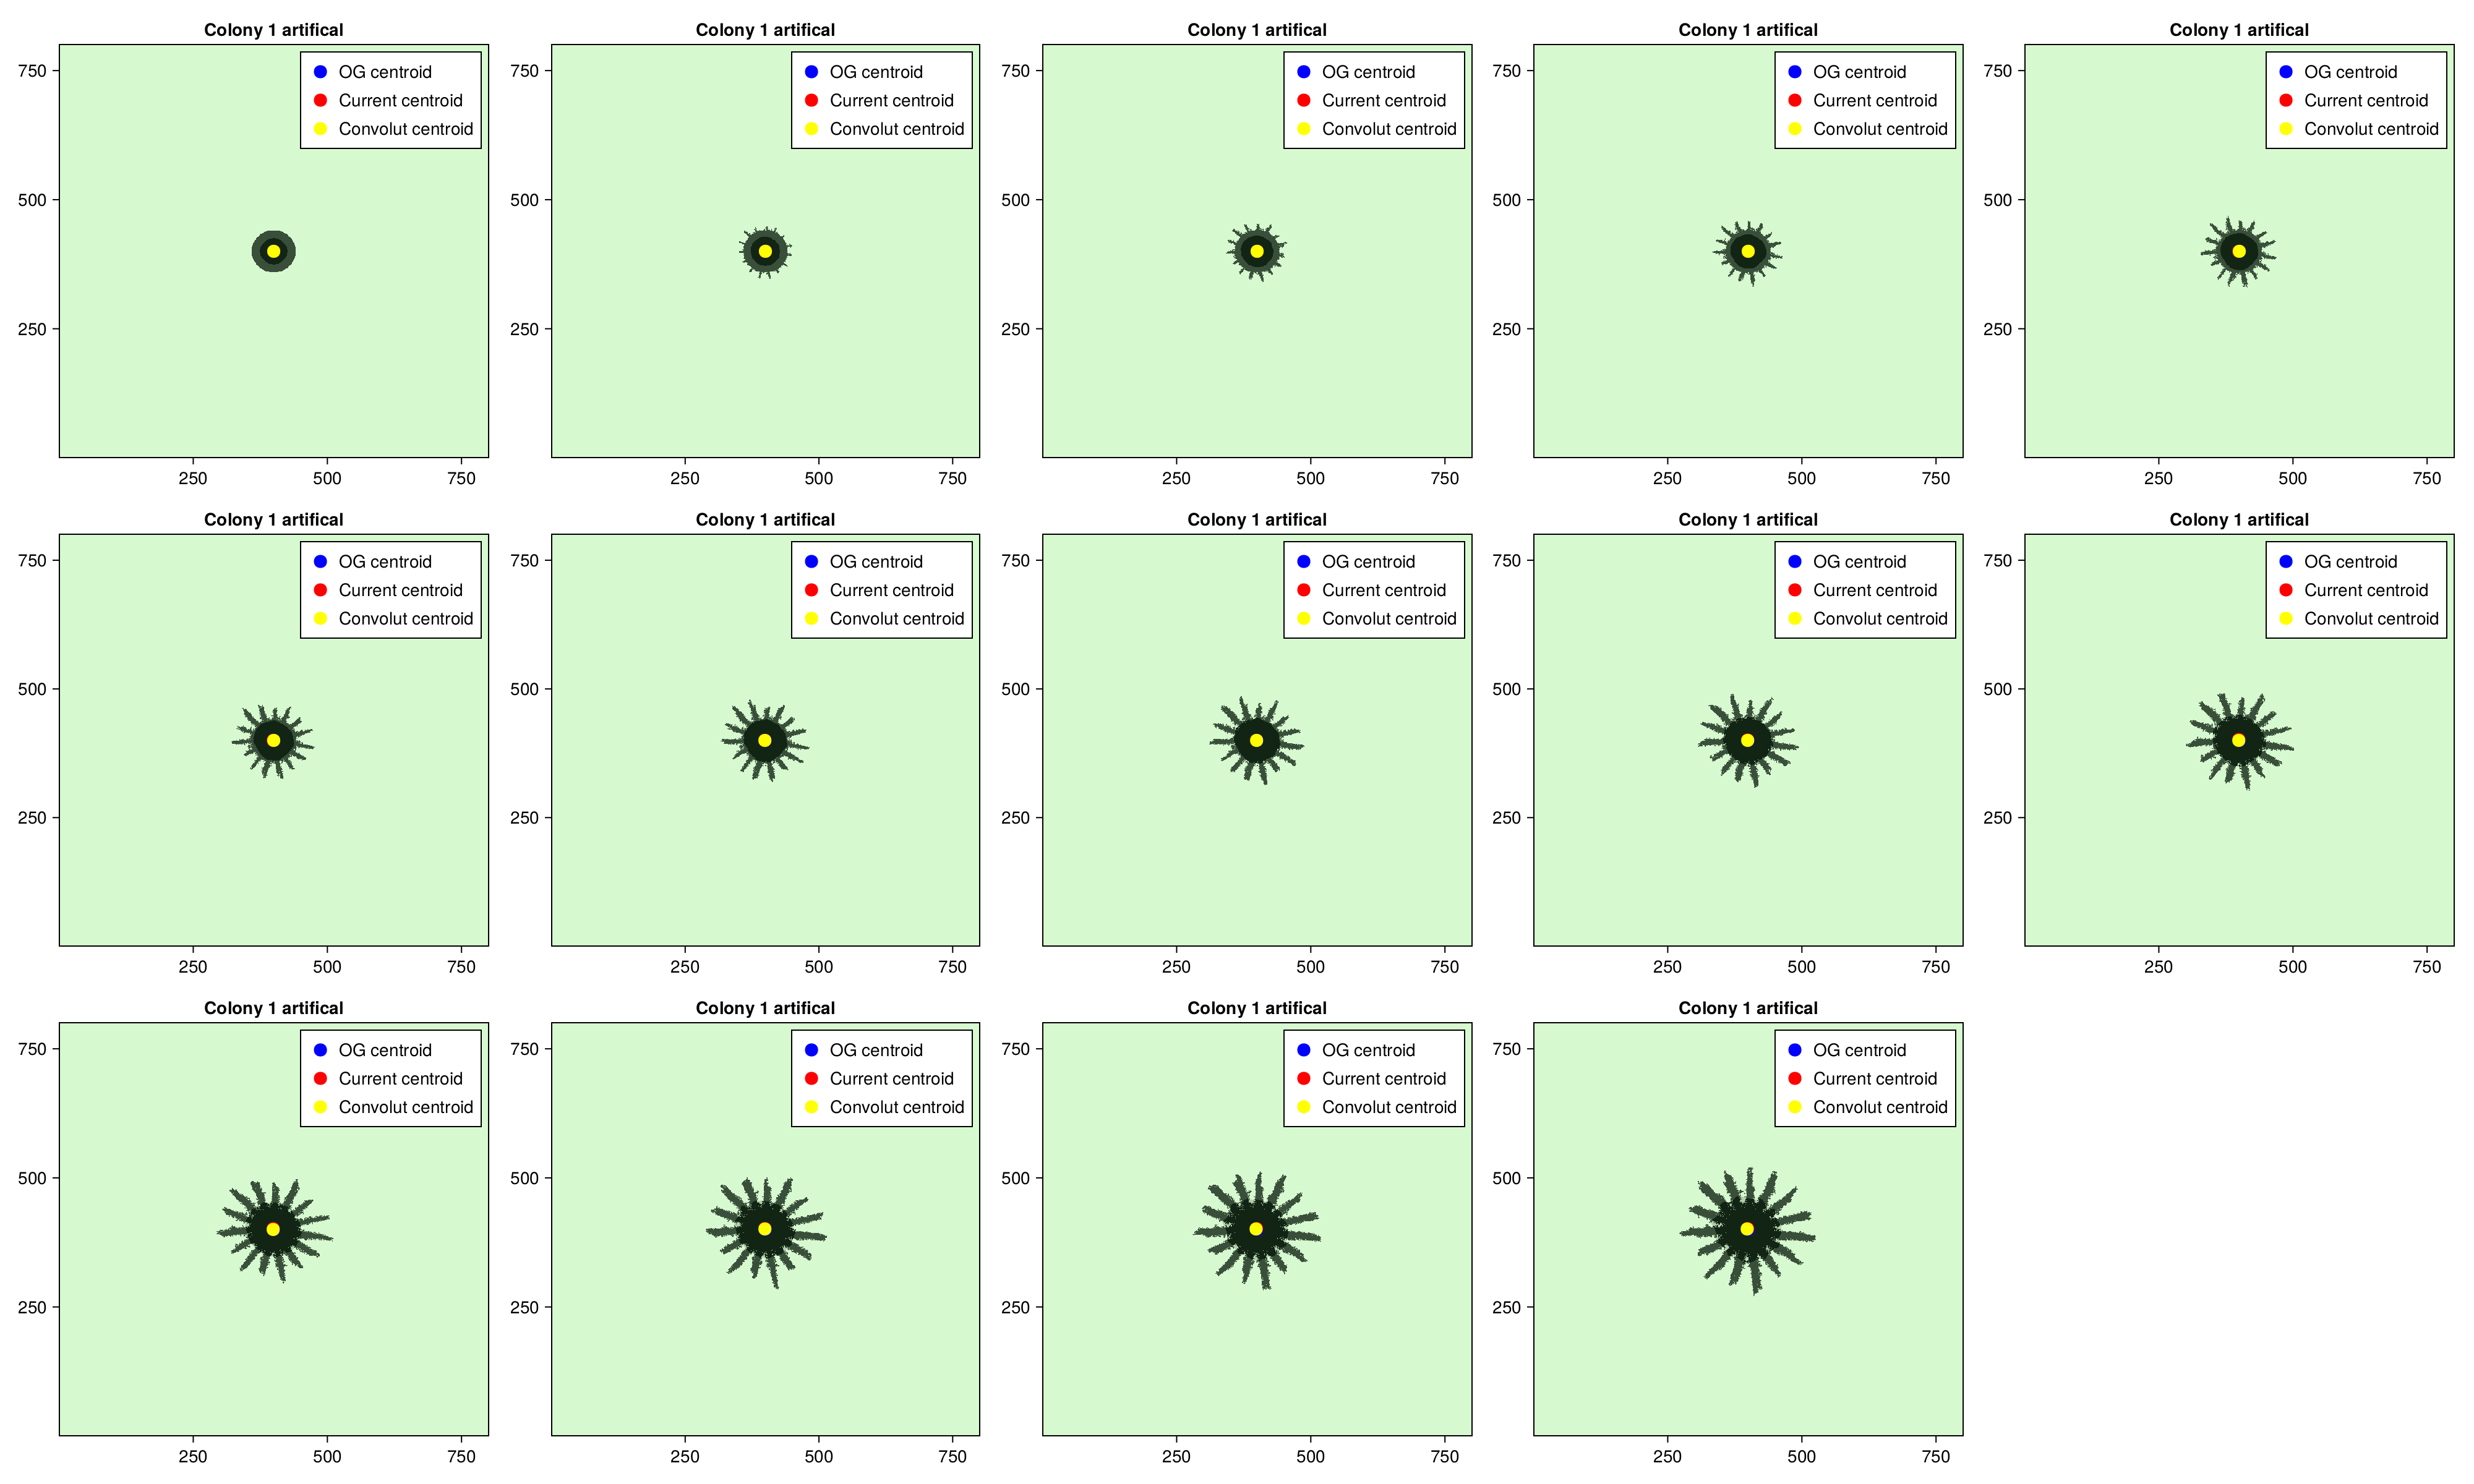

In [18]:
fig_test = plot_time_series_cov_centroid(vec_of_sims[2][1:1], para)

###  Calculate and append metrics to Dataframe

In [20]:
for (i,name) in collect(enumerate(para.simulations))
    save_time_series_metrics!(vec_of_sims[i], para,df,Points, name_data = name)
end

In [21]:
first(df,2)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size,border_points,Parameters
,String,String,Int64,Array…,Array…,Array…,Array…,Int64,Array…,paramete…
1,Random 2024_06_19,Colony 1 artifical,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[21, 2, 16, 14, 13, 14, 15, 15, 13, 18 … 13, 18, 13, 15, 15, 14, 13, 14, 16, 21]","[5435, 5098, 5450, 5583, 5551, 5354, 5697, 5591, 5585, 5490 … 5518, 5602, 5353, 5769, 5438, 5673, 5600, 5559, 5066, 6034]","[5544, 5105, 5623, 5814, 5520, 5522, 5728, 5640, 5680, 5634 … 5545, 5730, 5346, 5819, 5373, 5604, 5838, 5578, 5055, 5966]",5249,"CartesianIndex{2}[CartesianIndex(392, 360), CartesianIndex(393, 360), CartesianIndex(394, 360), CartesianIndex(395, 360), CartesianIndex(396, 360), CartesianIndex(397, 360), CartesianIndex(398, 360), CartesianIndex(399, 360), CartesianIndex(400, 360), CartesianIndex(401, 360) … CartesianIndex(399, 440), CartesianIndex(400, 440), CartesianIndex(401, 440), CartesianIndex(402, 440), CartesianIndex(403, 440), CartesianIndex(404, 440), CartesianIndex(405, 440), CartesianIndex(406, 440), CartesianIndex(407, 440), CartesianIndex(408, 440)]","parameters([0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, 32.0, 36.0, 40.0, 44.0, 48.0, 52.0], 0.7, 0.8, 0.4, 360, 2000000, 300, [800, 800], 14, 40, [400, 400], [0.029717, 0.0, 0.0, 0.0], #5, 0.01, [0 1 0; 1 -4 1; 0 1 0], 8, [""Colony 1 artifical"", ""Colony 2 artifical"", ""Colony 3 artifical"", ""Colony 4 artifical"", ""Colony 5 artifical"", ""Colony 6 artifical"", ""Colony 7 artifical"", ""Colony 8 artifical""], 2.0, [0.0, 0.124272, 0.263988, 0.421067, 0.597667, 0.796213, 1.01943, 1.27039, 1.55254, 1.86975, 2.22638, 2.62733, 3.07811, 3.5849], [0.124272, 0.139716, 0.157079, 0.176599, 0.198546, 0.22322, 0.25096, 0.282147, 0.31721, 0.356631, 0.40095, 0.450777, 0.506796], 15, 0.1, #7, 0.1, 0.9993, 0.9993, [""Random"", ""Finger_weak"", ""Finger_strong""])"
2,Random 2024_06_19,Colony 1 artifical,4,"[3, 5, 0, 1, 1, 1, 1, 1, 1, 0 … 1, 1, 3, 3, 1, 4, 3, 2, 0, 3]","[1, 3, 0, 1, 1, 0, 0, 1, 1, 1 … 0, 2, 1, 1, 0, 3, 3, 0, 0, 1]","[4820, 4906, 8555, 6086, 4276, 8131, 4223, 5945, 6509, 5128 … 5066, 6524, 6006, 4274, 8082, 4075, 5782, 7710, 4480, 6465]","[5347, 4212, 10494, 5701, 3934, 9757, 2703, 6791, 6167, 4882 … 5109, 5782, 7706, 3375, 9693, 3498, 5206, 9081, 4024, 7485]",5249,"CartesianIndex{2}[CartesianIndex(399, 355), CartesianIndex(404, 355), CartesianIndex(386, 356), CartesianIndex(399, 356), CartesianIndex(400, 356), CartesianIndex(403, 356), CartesianIndex(404, 356), CartesianIndex(409, 356), CartesianIndex(385, 357), CartesianIndex(387, 357) … CartesianIndex(400, 443), CartesianIndex(405, 443), CartesianIndex(406, 443), CartesianIndex(391, 444), CartesianIndex(393, 444), CartesianIndex(396, 444), CartesianIndex(397, 444), CartesianIndex(398, 444), CartesianIndex(393, 445), CartesianIndex(393, 446)]","parameters([0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, 32.0, 36.0, 40.0, 44.0, 48.0, 52.0], 0.7, 0.8, 0.4, 360, 2000000, 300, [800, 800], 14, 40, [400, 400], [0.029717, 0.0, 0.0, 0.0], #5, 0.01, [0 1 0; 1 -4 1; 0 1 0], 8, [""Colony 1 artifical"", ""Colony 2 artifical"", ""Colony 3 artifical"", ""Colony 4 artifical"", ""Colony 5 artifical"", ""Colony 6 artifical"", ""Colony 7 artifical"", ""Colony 8 artifical""], 2.0, [0.0, 0.124272, 0.263988, 0.421067, 0.597667, 0.796213, 1.01943, 1.27039, 1.55254, 1.86975, 2.22638, 2.62733, 3.07811, 3.5849], [0.124272, 0.139716, 0.157079, 0.176599, 0.198546, 0.22322, 0.25096, 0.282147, 0.31721, 0.356631, 0.40095, 0.450777, 0.506796], 15, 0.1, #7, 0.1, 0.9993, 0.9993, [""Random"", ""Finger_weak"", ""Finger_strong""])"


In [25]:
name_of_sim = "$(para.colony_nr)_col_$(length(para.simulations))_$(para.number_finger)_fingers"
path_metric = joinpath("data", "metrics")
mkpath(path_metric)

"data\\metrics"

In [26]:
serialize(joinpath(path_metric,"$(name_of_sim*Dates.format(now(), "yyyy_mm_dd")).jls"),df)
CSV.write(joinpath(path_metric,"$(name_of_sim*Dates.format(now(), "yyyy_mm_dd")).csv"),df)

"data\\metrics\\8_col_3_15_fingers2024_06_19.csv"